# **Script and outputs for training a CNN for model selection, perform cross-validation and predict the most likely model from empirical data in the species *Euphorbia segueriana*.**
From the manuscript Kirschner & Perez et al. (2022) "Congruent evolutionary responses of European steppe biota to late Quaternary climate change: insights from convolutional neural network-based demographic modeling".

All required files are available at the GitHub directory, except for the simulations, that can be downloaded here: https://drive.google.com/file/d/1XsOb03YkmwPsLT0DcSV8iWroNUJ-n0NV/view?usp=sharing. We will do the download with the next command.

In [97]:
#You need to download the empirical data.
!gdown --id 1XsOb03YkmwPsLT0DcSV8iWroNUJ-n0NV

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XsOb03YkmwPsLT0DcSV8iWroNUJ-n0NV
From (redirected): https://drive.google.com/uc?id=1XsOb03YkmwPsLT0DcSV8iWroNUJ-n0NV&confirm=t&uuid=4d772322-92a6-4051-b1ee-920b4c2dad17
To: /content/Part1_Dem_Models_simulations.zip
100% 47.6M/47.6M [00:01<00:00, 29.5MB/s]


##**Section 1: Building the CNN.**

In [98]:
# Import all required modules.

import sys, os
import numpy as np
import time
import random
from random import shuffle, choice
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
#from keras.utils import np_utils
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In the next cell we define the CNN architecture. Try to recognize each part of the architecture and associate them to the concepts presented during the lecture and what are their functions. Take notes if there is anything new or if you are not sure of what is the function of any of these parts.

In [99]:
# Define parameters for the CNN run.
batch_size = 128
### how much interations to train the network
epochs = 50

###n of models
num_classes = 3


# Define the CNN architecture.
def create_cnn(xtest):
	inputShape = (xtest.shape[1], xtest.shape[2])
	## image size. images need to have EXACTLY the same size
	inputs = Input(shape=inputShape)
	x = inputs
	## 1D convolution - less computational intensive and is also invariant to the samples order;
	x = Conv1D(256, kernel_size=2, activation='relu',input_shape=(xtest.shape[1], xtest.shape[2]))(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(128, kernel_size=2, activation='relu')(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(128, kernel_size=2, activation='relu')(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	### Linearising the image as in the initial step. From this point on the network behaves as a Multi-Layer Perceptron.
	x = Flatten()(x)
	x = Dense(128, activation='relu')(x)
	x = Dropout(0.5)(x)
	x = Dense(128, activation='relu')(x)
	x = Dropout(0.5)(x)
	x = Dense(num_classes, activation="softmax")(x)

	# Construct the CNN.
	model = Model(inputs, x)
	# Return the CNN.
	return model

## **Section 2: Train the network with 1,000 simulations from each model**

Now we are going to load the simulated data and train the network. First, unzip the folder containing the simulations and load them as 3-dimensional NumPy arrays (simulation, SNPs, samples). Associate each simulation with the appropriate label and shuffle their order.

In [100]:
#Unzip simulations
!unzip "/content/Part1_Dem_Models_simulations.zip"

#Load simulations from each model as a separate NumPy array
u1 = np.load("/content/Part1_Dem_Models_simulations/simulations/trainingSims/simModel1.npy",mmap_mode='r')
u2 = np.load("/content/Part1_Dem_Models_simulations/simulations/trainingSims/simModel2.npy",mmap_mode='r')
u3 = np.load("/content/Part1_Dem_Models_simulations/simulations/trainingSims/simModel3.npy",mmap_mode='r')

# Combine all arrays.
x=np.concatenate((u1,u2,u3),axis=0)

#For the real data we don't know which alleles are ancestral or derived.
#This function to transforms major alleles in -1 and minor in 1
for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 1] = -1
      x[arr][idx][x[arr][idx] == 0] = 1
    else:
      x[arr][idx][x[arr][idx] == 0] = -1

# Label each simulated array.
y=[0 for i in range(len(u1))]
y.extend([1 for i in range(len(u2))])
y.extend([2 for i in range(len(u3))])
y = np.array(y)

#delete temporary files to free memory.
del (u1,u2,u3)

# Shuffle the arrays for training, keeping the labels in the same order.
shf = list(range(len(x)))
shuffle(shf)
#Shuffle the labels (models)
y = y[shf]
#Shuffle the simulations using the same order of the labels.
x = x[shf]


Archive:  /content/Part1_Dem_Models_simulations.zip
replace Part1_Dem_Models_simulations/Part1_Dem_Models_Esegueriana.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Part1_Dem_Models_simulations/Part1_Dem_Models_Esegueriana.txt  
  inflating: __MACOSX/Part1_Dem_Models_simulations/._Part1_Dem_Models_Esegueriana.txt  
  inflating: __MACOSX/Part1_Dem_Models_simulations/._simulations  
  inflating: __MACOSX/Part1_Dem_Models_simulations/simulations/._testSims  
  inflating: Part1_Dem_Models_simulations/simulations/.DS_Store  
  inflating: __MACOSX/Part1_Dem_Models_simulations/simulations/._.DS_Store  
  inflating: __MACOSX/Part1_Dem_Models_simulations/simulations/._trainingSims  
  inflating: Part1_Dem_Models_simulations/simulations/testSims/.DS_Store  
  inflating: __MACOSX/Part1_Dem_Models_simulations/simulations/testSims/._.DS_Store  
  inflating: Part1_Dem_Models_simulations/simulations/testSims/parameters.txt  
  inflating: __MACOSX/Part1_Dem_Models_simulations/simulations/te

In [101]:
# Print label and simulations length, these should be the same.
print (len(x), len(y))

# Check array sizes as well just to be sure.
print (x.shape)

print (y.shape)

3000 3000
(3000, 1000, 270)
(3000,)


Now let's visualize the simulations as images. Check if you can extract some information from the images. For example, is it possible to separate individuals from the two different populations (remember that each sample is in a different column, and that the population samples are separated).

2


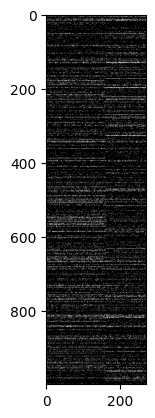

In [102]:
#Print the label and export an image from the training data, to visualize its appearance
print(y[0])
import matplotlib.pyplot as plt
plt.imshow(x[0],cmap='gray', vmin=-1, vmax=1)

np.int64(1)

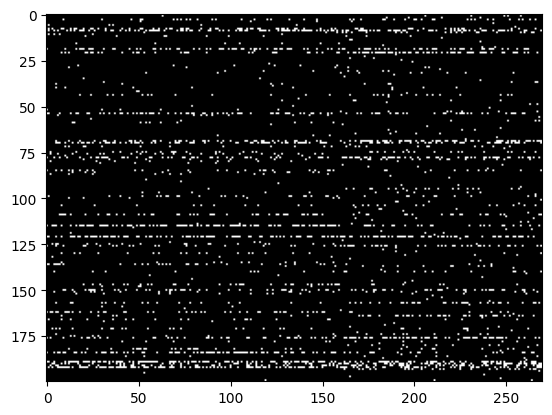

In [103]:
#You can also visualize a subset of the SNPs to better see the polymorphism.
import matplotlib.pyplot as plt
plt.imshow(x[1][0:200],cmap='gray', vmin=-1, vmax=1)
y[1]

In [104]:
#you can also visualize the array values (-1 for major and 1 to minor).
x[0]

array([[-1,  1,  1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ...,  1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1,  1, ..., -1, -1,  1]], dtype=int8)

Now we need to make the simulations look more like the real data. For that, we need to convert ancestral/derived alleles into major/minor. We also need to add missing data to the matrices.

In [105]:
# We will add missing data to the simulations as 0s.
# This is necessary beacuse the real data contains missing genotypes and
# we need to train the network to be able to recognize it.

#Add missing data (coded as 0s) to the simulated matrices
# as a percentage according to the empirical data (15% in E. segueriana).
missD_perc = 15
missD = int(x.shape[1]*x.shape[2]*(missD_perc/100))
for i in range(x.shape[0]):
    indices_2d = np.random.choice(x.shape[1], size=missD, replace=True)
    indices_3d = np.random.choice(x.shape[2], size=missD, replace=True)
    x[i, indices_2d, indices_3d] = 0
del(missD)

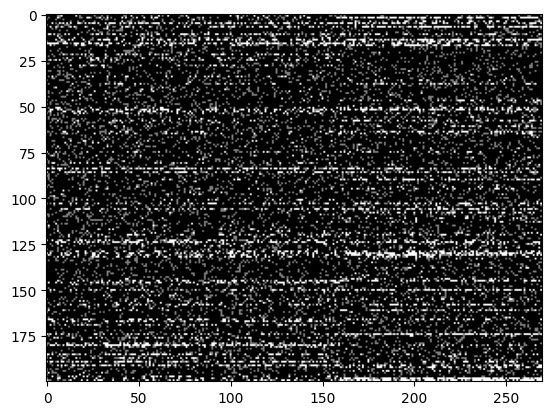

In [106]:
#Export an image from the training data, to visualize its appearance.
#Note how missing data (in grey) make it much more difficult to detect patterns.
import matplotlib.pyplot as plt
plt.imshow(x[0][0:200],cmap='gray', vmin=-1, vmax=1)

In [107]:
#And visualize the array values.
x[0]

array([[-1,  1,  1, ..., -1,  0, -1],
       [-1, -1, -1, ..., -1, -1,  0],
       [-1,  0, -1, ...,  1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1,  1, ...,  0, -1,  1]], dtype=int8)

Now we need to separate the training simulations into the training and validation sets. Do you remember what are these sets used to? We don't need to define the test now, but do you remember what will it be used to?

We will also compile the architecture, define the optimzer and set an Early Stopping approach.

In [111]:
# Separate train (75%) and validate (25%) sets.
xtrain, xval = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, yval = y[int(len(y)*.25):], y[:int(len(y)*.25)]

#Dividind into classes
yval = np.eye(num_classes)[yval]
ytrain = np.eye(num_classes)[ytrain]

# Create the CNN network.
model = create_cnn(xval)

# Compile the CNN.
model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer='Adam',
	              metrics=['accuracy'])

# We will use early stopping and save the model with the best val_accuracy.
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=25, verbose=0, mode='max', restore_best_weights=True)
### stop training when validation error increases (wait 25 epochs to see if there is any improvement).

# Check the architecture.
model.summary()


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 1000, 270)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 999, 256)            │         138,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_41                 │ (None, 499, 256)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 499, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_42 (Conv1D)                   │ (None, 498, 128)            │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_42                 │ (None, 249, 128)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 249, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 248, 128)            │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_43                 │ (None, 124, 128)            │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 124, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 15872)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 128)                 │       2,031,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,287,747 (8.73 MB)

 Trainable params: 2,286,723 (8.72 MB)

 Non-trainable params: 1,024 (4.00 KB)

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-dikl_gbl
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-dikl_gbl
  Resolved https://github.com/paulgavrikov/visualkeras to commit 467872c770562592a96392be6232c99fe3c48605
  Preparing metadata (setup.py) ... done


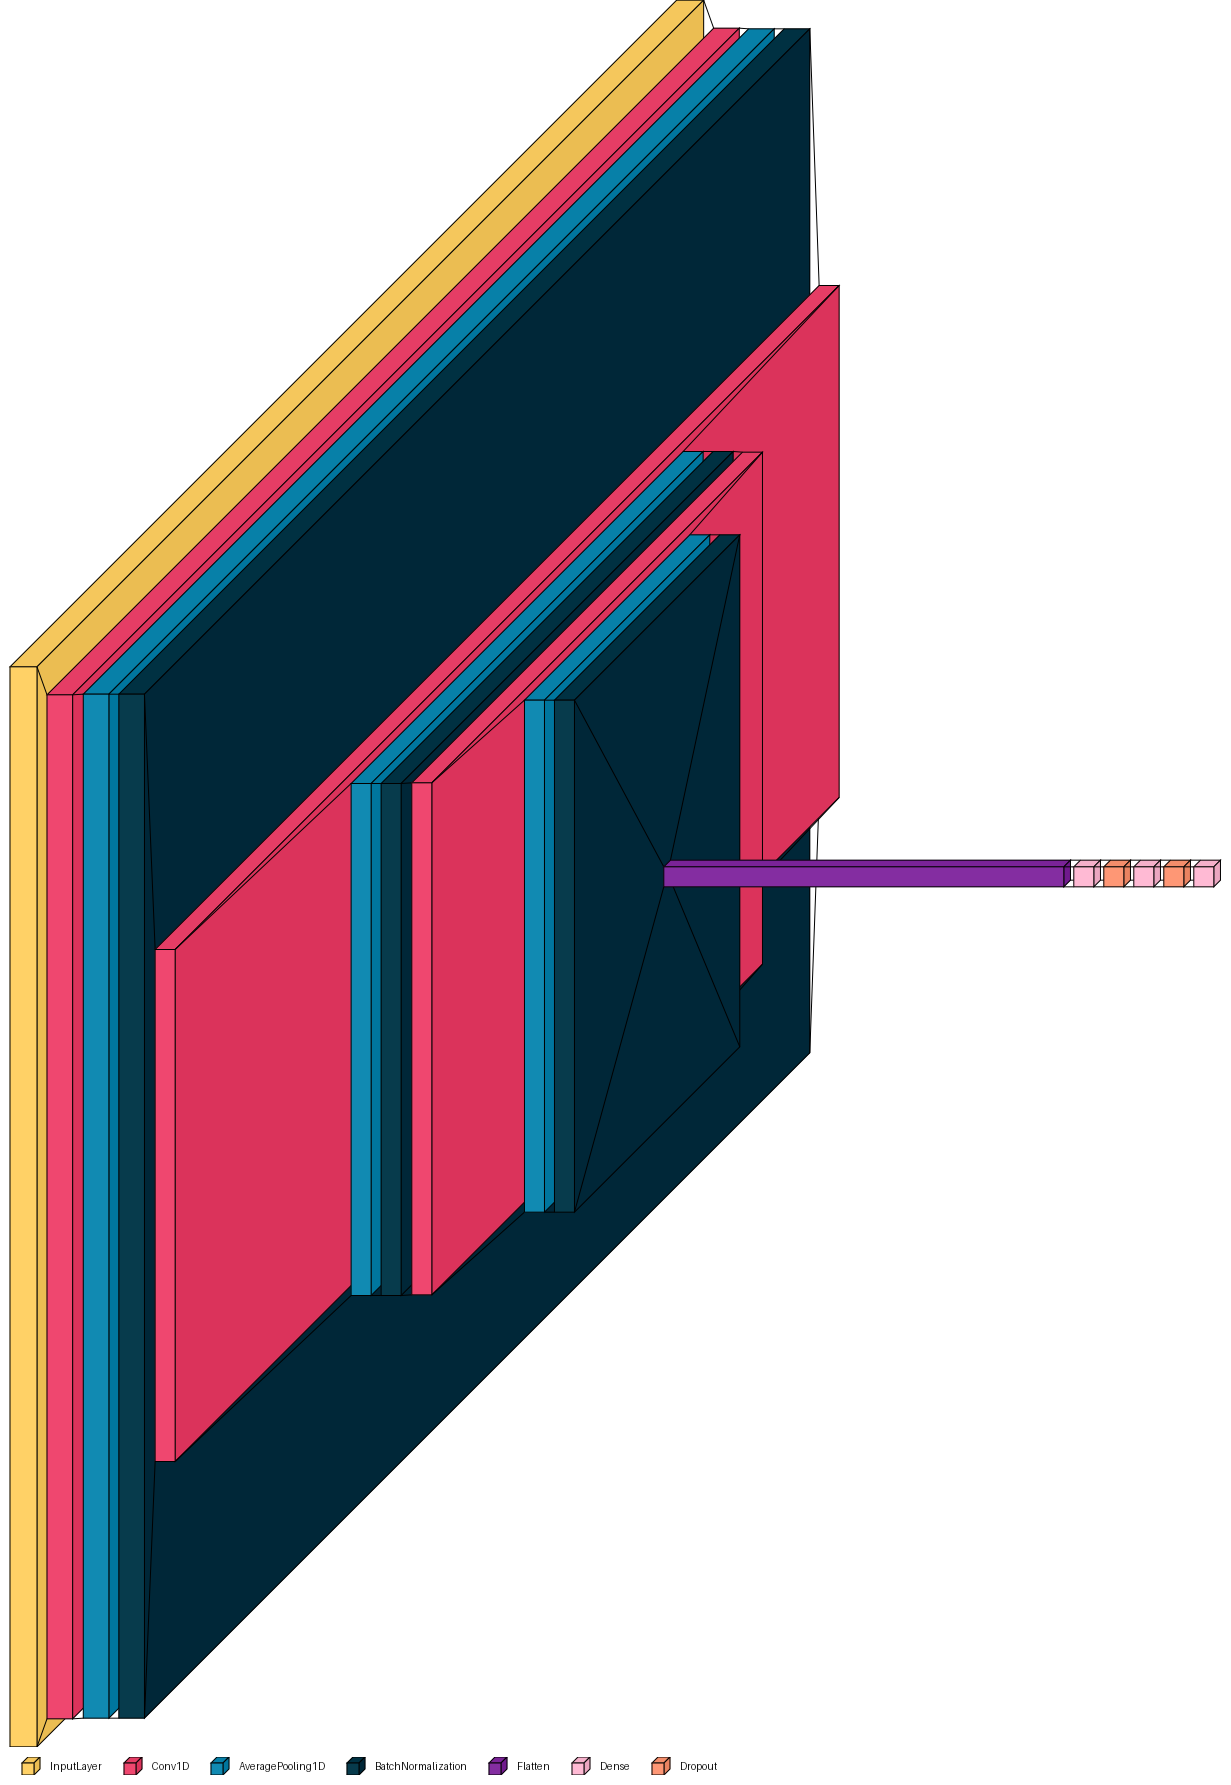

In [112]:
#We can also have a graphical visualization of the layers
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

No it's time to train the network. This will take some time. While it's training we can discuss the previous steps of the script.

In [113]:
#Run the CNN
history = model.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xval, yval),callbacks=[earlyStopping])

# Save the model.
model.save(filepath='Trained_Esegueriana._MissingData.acc.keras')

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 685ms/step - accuracy: 0.5766 - loss: 1.0794 - val_accuracy: 0.3387 - val_loss: 24.0454
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.7912 - loss: 0.5583 - val_accuracy: 0.3387 - val_loss: 10.3739
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8482 - loss: 0.3956 - val_accuracy: 0.3387 - val_loss: 19.2293
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.8984 - loss: 0.2840 - val_accuracy: 0.0893 - val_loss: 4.2218
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9364 - loss: 0.1713 - val_accuracy: 0.3213 - val_loss: 8.3084
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9533 - loss: 0.1148 - val_accuracy: 0.3213 - val_loss: 10.4926
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9726 - loss: 0.0816 - val_accuracy: 0.3213 - val_loss: 13.8194
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9846 - loss: 0.0535 - val_accuracy: 0.3

After training we need to evaluate if the network is learning and not overfitting. The next commands will plot the accuracy in the training and validation sets.

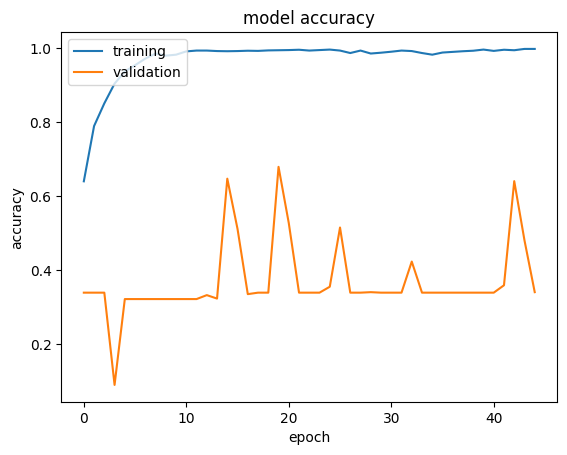

In [114]:
# Plot training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

What do you think about this curves? Do you think that training was properly done? Can you think of ways to improve it?

## **Section 3: Perform cross validation predictions with another 100 simulations per model. Those were not seen by the network during training**

Now we are going to test the trained model using the test set. These are new simulations that were not used by the network during the training. The idea here is to use simulaiton as if they are our real data (we call this pseudoobserved data in ABC) and see what the network predicts for each of these simulations. After that we compare the predicted values with the real (simulated) ones.

300 300
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


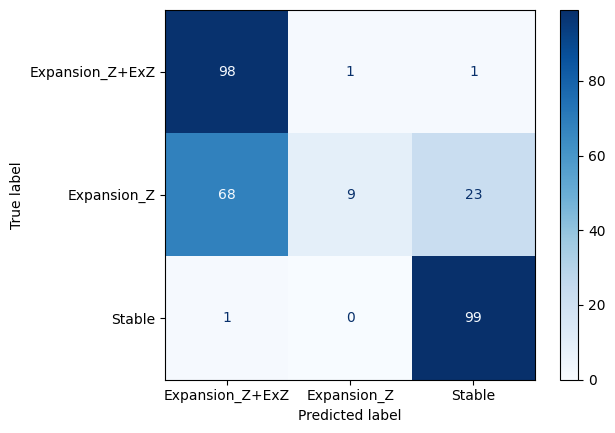

In [115]:
# Load Numpy test set arrays containing the test set simulations.
u1 = np.load("/content/Part1_Dem_Models_simulations/simulations/testSims/simModel1.npy",mmap_mode='r') #Expansion in both
u2 = np.load("/content/Part1_Dem_Models_simulations/simulations/testSims/simModel2.npy",mmap_mode='r') #Expansion in Zonal only
u3 = np.load("/content/Part1_Dem_Models_simulations/simulations/testSims/simModel3.npy",mmap_mode='r') #No expansion

# Combine all test set arrays.
xtest=np.concatenate((u1,u2,u3),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(xtest):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      xtest[arr][idx][xtest[arr][idx] == 1] = -1
      xtest[arr][idx][xtest[arr][idx] == 0] = 1
    else:
      xtest[arr][idx][xtest[arr][idx] == 0] = -1

# Label each simulated array.
ytest=[0 for i in range(len(u1))]
ytest.extend([1 for i in range(len(u2))])
ytest.extend([2 for i in range(len(u3))])
ytest = np.array(ytest)

#delete temporary files to free memory.
del (u1,u2,u3)

# Print label and simulations length, these should be the same.
print (len(xtest), len(ytest))

#Add missing data (coded as 0s) to the simulated matrices
# as a percentage according to the empirical data (15% in E. segueriana).
missD_perc = 15
missD = int(xtest.shape[1]*xtest.shape[2]*(missD_perc/100))
for i in range(xtest.shape[0]):
    indices_2d = np.random.choice(xtest.shape[1], size=missD, replace=True)
    indices_3d = np.random.choice(xtest.shape[2], size=missD, replace=True)
    xtest[i, indices_2d, indices_3d] = 0
del(missD)

# Predict with the trained model and export a confusion matrix.
pred = model.predict(xtest)
pred_cat = [i.argmax() for i in pred]
cm=confusion_matrix(ytest, pred_cat)
scenarios = ['Expansion_Z+ExZ', 'Expansion_Z', 'Stable']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scenarios)

disp.plot(cmap=plt.cm.Blues)
plt.show()

Please take a moment to analyze the confusion matrix. Can you detect which models are more difficult to predict? For those, what is the other model that is creating this confusion?

The architecture we used above was the same we used on the paper. The only difference here is the size of the training data, which has less simulations here (1,000 per model against 10,000 per model in the paper). Now let's try to improve our results by changing the network architecture. Can you think about ways to improve it based on what we discussed? I added some the code to build a modified architecture below. Take a look on the results and think about the modifications I made on the architecture.

In [116]:
# Define the CNN architecture. You can now change some parts of it and see how it behaves.
def create_cnn(xtest):
	inputShape = (xtest.shape[1], xtest.shape[2])
	## image size. images need to have EXACTLY the same size
	inputs = Input(shape=inputShape)
	x = inputs
	## 1D convolution - less computational intensive and is also invariant to the samples order;
	x = Conv1D(64, kernel_size=2, activation='relu',input_shape=(xtest.shape[1], xtest.shape[2]))(x)
	x = Dropout(0.5)(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(32, kernel_size=2, activation='relu')(x)
	x = Dropout(0.5)(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	### Linearising the image as in the initial step. From this point on the network behaves as a Multi-Layer Perceptron.
	x = Flatten()(x)
	x = Dense(32, activation='relu', kernel_regularizer=l1_l2(0.0001))(x)
	x = Dropout(0.5)(x)
	x = Dense(16, activation='relu', kernel_regularizer=l1_l2(0.0001))(x)
	x = Dropout(0.5)(x)
	x = Dense(num_classes, activation="softmax")(x)

	# Construct the CNN.
	model = Model(inputs, x)
	# Return the CNN.
	return model

In [117]:
# Create the CNN network.
model = create_cnn(xval)

# Compile the CNN.
model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer='Adam',
	              metrics=['accuracy'])

# We will use early stopping and save the model with the best val_accuracy.
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=25, verbose=0, mode='max', restore_best_weights=True)
### stop training when validation error increases (wait 25 epochs to see if there is any improvement).

# Check the architecture.
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 1000, 270)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_44 (Conv1D)                   │ (None, 999, 64)             │          34,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 999, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_44                 │ (None, 499, 64)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 499, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_45 (Conv1D)                   │ (None, 498, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 498, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_45                 │ (None, 249, 32)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 249, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 7968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 32)                  │         255,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,723 (1.12 MB)

 Trainable params: 294,531 (1.12 MB)

 Non-trainable params: 192 (768.00 B)

In [118]:
#Run the CNN
history = model.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xval, yval),callbacks=[earlyStopping])

# Save the model.
model.save(filepath='Trained_Esegueriana._MissingData.acc.keras')

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 796ms/step - accuracy: 0.3969 - loss: 1.8737 - val_accuracy: 0.3387 - val_loss: 4.1688
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5451 - loss: 1.4235 - val_accuracy: 0.3213 - val_loss: 1.6259
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5722 - loss: 1.3031 - val_accuracy: 0.3213 - val_loss: 1.5164
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5724 - loss: 1.2312 - val_accuracy: 0.3213 - val_loss: 1.5313
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5896 - loss: 1.2200 - val_accuracy: 0.3213 - val_loss: 1.5693
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6387 - loss: 1.1246 - val_accuracy: 0.3213 - val_loss: 1.5277
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6433 - loss: 1.0936 - val_accuracy: 0.3213 - val_loss: 1.5511
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6265 - loss: 1.0950 - val_accuracy: 0.3227 -

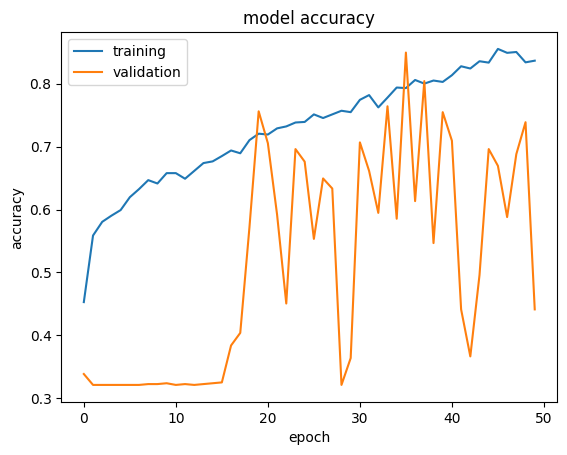

In [119]:
# Plot training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


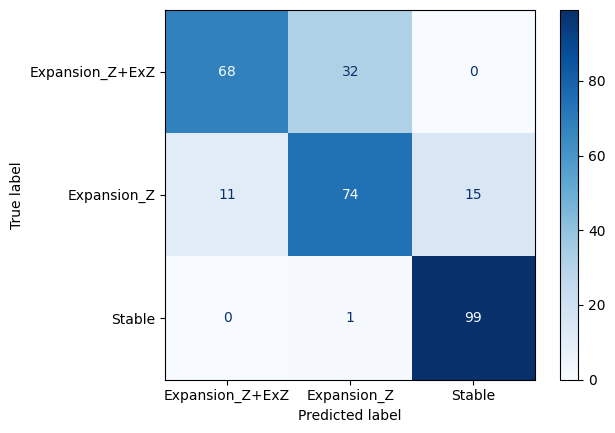

In [121]:
# Predict with the trained model and export a confusion matrix.
pred = model.predict(xtest)
pred_cat = [i.argmax() for i in pred]
cm=confusion_matrix(ytest, pred_cat)
scenarios = ['Expansion_Z+ExZ', 'Expansion_Z', 'Stable']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scenarios)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## **Section 4: Predict the most likely model for the empirical data, using the trained CNN.**

In [122]:
# Load empirical data.
infile=np.loadtxt("/content/Part1_Dem_Models_simulations/Part1_Dem_Models_Esegueriana.txt")
inp=np.array(infile)

inp.shape

(12125, 270)

In [123]:
# Create 100 subsets containing 1,000 random SNPs from the full empirical data.
num_samples=100
res = []
for i in range(0,num_samples):
	idx = np.random.choice(inp.shape[0], 1000, replace=False)
	n = inp[idx,:]
	res.append(np.array(n))

Emp = np.array(res)

# Predict model probabilities for each of the 100 subsets.
Emp_pred = model.predict(Emp)

# Print for each subset
print(Emp_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
[[0.3777176  0.60652965 0.01575273]
 [0.46858722 0.52077943 0.01063338]
 [0.58774114 0.40652347 0.00573547]
 [0.5002191  0.48894772 0.0108332 ]
 [0.24857308 0.7430403  0.00838658]
 [0.64598954 0.35021567 0.00379479]
 [0.18374458 0.8118403  0.00441501]
 [0.48644862 0.5037078  0.00984359]
 [0.35085335 0.6315186  0.01762811]
 [0.5903701  0.4037807  0.00584923]
 [0.44025657 0.55374426 0.00599921]
 [0.50629294 0.4859374  0.00776965]
 [0.3278217  0.6602015  0.01197684]
 [0.3668501  0.6125774  0.02057251]
 [0.6642012  0.3335544  0.00224442]
 [0.35496792 0.6347227  0.01030932]
 [0.44651577 0.5425018  0.01098243]
 [0.46328467 0.5170542  0.01966114]
 [0.46589372 0.5283111  0.00579519]
 [0.6880282  0.3095719  0.00239992]
 [0.4776235  0.507811   0.01456546]
 [0.4955148  0.49656343 0.00792175]
 [0.53854114 0.45875835 0.00270047]
 [0.576119   0.41843456 0.00544645]
 [0.4189523  0.5628441  0.01820364]
 [0.6391033  0.35674638 0.00415036]
 [0.28235045 0.7106751  0

In [124]:
# Print the average of all subsets
np.mean(Emp_pred, axis=0)


array([0.4706192 , 0.51965934, 0.00972142], dtype=float32)

Which scenario was selected? Is this in agreement with the one obtained in the paper for *E. segueriana?* (model 2 - Zonal expansion only). Check with your colleagues whether they recovered the same scenario as you. If not, can you explain why this is the case?

## **Section 5: We can also perform parameter estimation.**

Now we can use the same architecture (with a slight difference in the last layer) to perform parameter estimation. To make things simple, we will focus only in the simulations under the selected scenario (model 2). We will also need to change the labels of each simulation to the parameter values used.

In [129]:
def create_cnn(xtest):
	inputShape = (xtest.shape[1], xtest.shape[2])
	## image size. images need to have EXACTLY the same size
	inputs = Input(shape=inputShape)
	x = inputs
	## 1D convolution - less computational intensive and is also invariant to the samples order;
	x = Conv1D(64, kernel_size=2, activation='relu',input_shape=(xtest.shape[1], xtest.shape[2]))(x)
	x = Dropout(0.5)(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(32, kernel_size=2, activation='relu')(x)
	x = Dropout(0.5)(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	### Linearising the image as in the initial step. From this point on the network behaves as a Multi-Layer Perceptron.
	x = Flatten()(x)
	x = Dense(32, activation='relu', kernel_regularizer=l1_l2(0.0001))(x)
	x = Dropout(0.5)(x)
	x = Dense(16, activation='relu', kernel_regularizer=l1_l2(0.0001))(x)
	x = Dropout(0.5)(x)
	x = Dense(numParams)(x)# This was the only change in the architecture.

	# Construct the CNN.
	model = Model(inputs, x)
	# Return the CNN.
	return model

In [130]:
from sklearn.preprocessing import StandardScaler

# Load parameters.
demogParams = readDemogParams('/content/Part1_Dem_Models_simulations/simulations/trainingSims/parameters.txt')
y = np.array(demogParams)
numParams=y.shape[1]

#delete temporary files to free memory.
del (demogParams)

#We need to standard scale the parameters, as they can be on very different scales.
scaler= StandardScaler()
y = scaler.fit_transform(y)

#Load simulations for the best model.
u3 = np.load("/content/Part1_Dem_Models_simulations/simulations/trainingSims/simModel2.npy",mmap_mode='r')
x = np.array(u3)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 1] = -1
      x[arr][idx][x[arr][idx] == 0] = 1
    else:
      x[arr][idx][x[arr][idx] == 0] = -1

# Print label and simulations length, these should be the same.
print (len(x), len(y))

# Shuffle the arrays for training, keeping the labels in the same order.
shf = list(range(len(x)))
shuffle(shf)
y = y[shf]
x = x[shf]

#Add missing data (coded as 0s) to the simulated matrices
# as a percentage according to the empirical data (15% in E. segueriana).
missD_perc = 15
missD = int(x.shape[1]*x.shape[2]*(missD_perc/100))
for i in range(x.shape[0]):
    indices_2d = np.random.choice(x.shape[1], size=missD, replace=True)
    indices_3d = np.random.choice(x.shape[2], size=missD, replace=True)
    x[i, indices_2d, indices_3d] = 0
del(missD)

# Separate train (75%) and validate (25%) sets.
xtrain, xtest = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
del(x)

# Create the CNN network.
cnn = create_cnn(xtest)

# Compile the CNN.
cnn.compile(loss='mean_squared_error', #the loss is now defined as the mean squared error, as we have continuous labels
	              optimizer='Adam')

# Check the architecture.
cnn.summary()

# Run the CNN with early stopping. Save the model with the best val_accuracy.
earlyStopping = EarlyStopping(monitor='val_loss', patience=25, verbose=0, mode='max', restore_best_weights=True)

history = cnn.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])

1000 1000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 1000, 270)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_49 (Conv1D)                   │ (None, 999, 64)             │          34,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 999, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_49                 │ (None, 499, 64)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 499, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_50 (Conv1D)                   │ (None, 498, 32)             │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 498, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_50                 │ (None, 249, 32)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 249, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 7968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 32)                  │         255,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,876 (1.12 MB)

 Trainable params: 294,684 (1.12 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 3.4570 - val_loss: 1.9179
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 3.0722 - val_loss: 2.1230
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 2.8082 - val_loss: 2.2609
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 2.5289 - val_loss: 2.0955
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 2.2469 - val_loss: 1.9011
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.9828 - val_loss: 1.7630
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.8780 - val_loss: 1.6004
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.7676 - val_loss: 1.5145
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.6113 - val_loss: 1.5280
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.5922 - val_loss: 1.4929
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.6105 - val_loss: 1.4375
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.4929 - val_loss: 1.3736
Ep

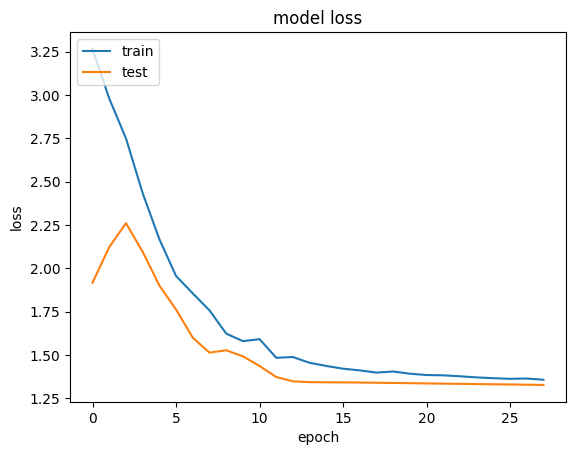

In [133]:
# Plot training and validation accuracies
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##**Now let's predict the real data.**


In [134]:

# Create 100 subsets containing 1,000 random SNPs from the full empirical data.
num_samples=100
res = []
for i in range(0,num_samples):
	idx = np.random.choice(inp.shape[0], 1000, replace=False)
	n = inp[idx,:]
	res.append(np.array(n))

# Predict parameters.
Emp_pred = np.array(res)
Emp_pred = cnn.predict(Emp_pred)
Emp_pred = scaler.inverse_transform(Emp_pred)

#Print parameter names
print('Theta, T1, T2, T3, Ne, NeZ, NeExZLGM, NeZLGM, NeExZPl, NeZPl, m12_Pres, m21_Pres, m12_LGM, m21_LGM, m12_Pl, m21_Pl')
#Print parameter values (averaged over subsets)
print(np.mean(Emp_pred, axis=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step
Theta, T1, T2, T3, Ne, NeZ, NeExZLGM, NeZLGM, NeExZPl, NeZPl, m12_Pres, m21_Pres, m12_LGM, m21_LGM, m12_Pl, m21_Pl
[ 2.7155733e-01  7.9684938e+05  7.6390875e+04  9.5640195e+03
  1.6071956e+05  1.4999650e+00  7.1456757e+01  7.4065053e-01
 -8.9319706e-02  3.0856352e+00  4.9986992e+00  5.3231020e+00]


Now you have just obtained an estimate of parameter values for the empirical data. Notice that these are point estimates (average over 100 subsets). Is this different from the type of results you obtained with ABC? Can you think of potential approaches to estimate uncertainty (feel free to try something below)?